In [54]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rikabplotlib.plot_utils import newplot

import torch
import zuko

In [55]:
# Physics Parameters
E0 = 500
R = 0.4



# Training Params
mode = "FORWARD" #"REVERSE"
epochs = 1250
batch_size = 256
lr = 1e-4
epsilon = 1e-9 # For numerical stability, can probably set to 0
auxiliary_params = 1 # Number of auxiliary parameters to use in the model, 0 has different behavior!
num_transforms = 3 # I think this is the number of layers?
hidden_features=(32, 32)
x_range = (0, 1) # Range of x values to train on, should be at least as large as the support of the data


In [56]:
# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p



def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num(((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_)) )* Theta(lambda_)* Theta(1-lambda_)

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))


# Choice of target
target_p = LL_angularity

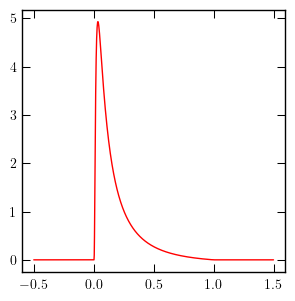

In [57]:
# Plot the target distribution

fig, ax = newplot("column")

xs = np.linspace(-0.5, 1.5, 1000)
ys = target_p(torch.tensor(xs)).detach().numpy()
ax.plot(xs, ys, label="LL Angularity", color = "red")


In [58]:
import torch
from torch import Tensor
from torch.distributions import constraints
from zuko.transforms import Transform


class AffineSigmoid(Transform):
    r"""
    Affine Sigmoid transformation that maps from real numbers to the interval (a, b).

    Arguments:
        a (float): The lower bound of the interval.
        b (float): The upper bound of the interval.
    """

    bijective = True

    def __init__(self, a: float, b: float, **kwargs):
        super().__init__(**kwargs)
        self.a = a
        self.b = b
        self.domain = constraints.real
        self.codomain = constraints.interval(a, b)

    def _call(self, x: Tensor) -> Tensor:
        # Forward transformation: x in R -> y in (a, b)
        s = torch.sigmoid(x)
        y = self.a + (self.b - self.a) * s
        return y

    def _inverse(self, y: Tensor) -> Tensor:
        # Inverse transformation: y in (a, b) -> x in R
        s = (y - self.a) / (self.b - self.a)
        x = torch.log(s) - torch.log1p(-s)
        return x

    def log_abs_det_jacobian(self, x: Tensor, y: Tensor) -> Tensor:
        # Log absolute determinant of the Jacobian
        sigma_x = torch.sigmoid(x)
        log_det = torch.log(self.b - self.a) + torch.log(sigma_x) + torch.log1p(-sigma_x)
        return log_det

In [59]:
from zuko.distributions import DiagNormal
from zuko.flows import UnconditionalDistribution

# Initialize the flow

# Can choose: NSF, MAF, NICE
flow = zuko.flows.NSF(features = auxiliary_params + 1, transforms= num_transforms, hidden_features=hidden_features)

# # Hack to make the flow bounded between 0 and 1
# flow = zuko.flows.Flow(transform = [flow, AffineSigmoid(0,1)], base =UnconditionalDistribution(
#         DiagNormal,
#         torch.zeros(3),
#         torch.ones(3),
#         buffer=True,
#     ),)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def inverse_sigmoid(x):
    return torch.log(x / (1 - x))

def log_abs_det_jacobian_sigmoid(x,):
    sigma = sigmoid(x)
    return torch.abs(torch.log(sigma) + torch.log(1 - sigma))


print(flow)

# print list of all attributes of the flow
print(flow.__dict__.keys())

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)


pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")


NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

In [60]:
# Training Loop

PLOT_EACH_EPOCH = False
t = tqdm(range(epochs))
losses = []

for epoch in t:

    if mode == "REVERSE":



        xs = flow().sample((batch_size,1))
        logq = flow().log_prob(xs)
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,:,0])


        loss = torch.nanmean((logq - logp))
        loss.backward()

    # Used to be called "REVERSE" / "No samples"
    if mode == "FORWARD":


        xs = torch.rand(batch_size, auxiliary_params + 1)  * (x_range[1] - x_range[0]) + x_range[0]

        # Auxillary variable -- uniform. alternatively set to const
        if auxiliary_params > 0:
            xs[:,1:] = torch.rand(batch_size, auxiliary_params)

        # Note for log_prob to work, we need to pass a tensor of shape (batch_size, >=1)
        logJ = np.sum(log_abs_det_jacobian_sigmoid(xs), axis = 1)
        logq = flow().log_prob(inverse_sigmoid(xs)) + logJ
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,0])
        # technically need to adjust logp if aux is anything other than U(0,1)

        # Bou


        loss = torch.nanmean(torch.exp(logp) * ( - logq))
        loss.backward()

    if PLOT_EACH_EPOCH:
        if epoch % 1 == 0:
            fig, ax = newplot("column")

            ys = torch.exp(logp).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Target", color = "red")

            ys = torch.exp(logq).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Flow", color = "blue")
            plt.yscale("log")   
            plt.legend()

            plt.show()


    # Gradient Descent
    optimizer.step()
    optimizer.zero_grad()



    losses.append(loss.item())
    t.set_description(f"Loss: {loss.item()}")



Loss: 3.1303043365478516:   0%|          | 5/1250 [00:02<10:05,  2.05it/s]

Loss: 1.7382704019546509: 100%|██████████| 1250/1250 [03:16<00:00,  6.36it/s]


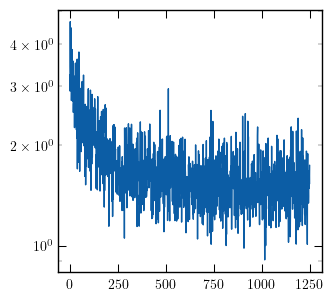

In [61]:
fig, ax = newplot("column")

ax.plot(losses)
plt.yscale("log")

Text(0, 0.5, 'Aux 0')

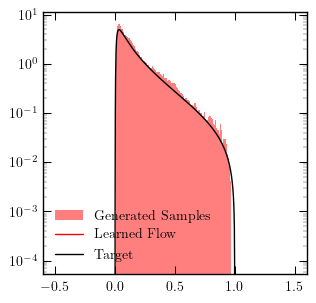

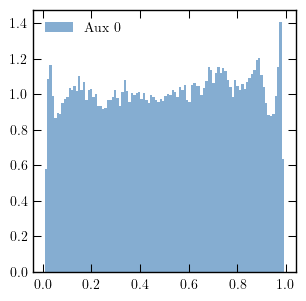

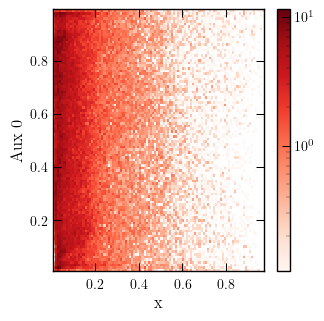

In [66]:
# Plot distribution of xs


samples = sigmoid(flow().sample((100000,)))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()

fig, ax = newplot("column")

plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5, label = "Generated Samples")


xs = torch.zeros((1000, auxiliary_params + 1))
xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
logJ = np.sum(log_abs_det_jacobian_sigmoid(xs), axis = 1)
ys = (flow().log_prob(inverse_sigmoid(xs)) + logJ).exp()

xs = xs[:,0].detach().numpy().flatten()
ys = ys.detach().numpy().flatten()
plt.plot(xs, ys, color = "red", label = "Learned Flow")


plt.plot(xs, target_p(torch.tensor(xs)), color = "Black", label = "Target")

plt.legend()

plt.yscale("log")

# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = newplot("column")
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow().log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")
    plt.legend()

# correlation between auxiliary variable 1 and x
import matplotlib as mpl
fig, ax = newplot("column")
bar = ax.hist2d(x_samples, aux_samples[:,0], bins=100, density=True, norm=mpl.colors.LogNorm(), cmap="Reds")
plt.colorbar(bar[3])
plt.xlabel("x")
plt.ylabel("Aux 0")


In [63]:
# #  Plot distribution of xs


# samples = flow().sample((100000,)).detach().numpy()
# x_samples = samples[:,0]
# aux_samples = samples[:,1:]

# fig, ax = newplot("column")

# plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5)


# xs = torch.zeros((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
# ys = flow().log_prob(xs).exp()

# xs = xs[:,0].detach().numpy().flatten()
# ys = ys.detach().numpy().flatten()
# plt.plot(xs, ys, color = "red")


# plt.plot(xs, target_p(torch.tensor(xs)), color = "blue")

# plt.yscale("log")

# # plot the auxiliary variables
# if auxiliary_params > 0:
#     fig, ax = newplot("column")
#     for i in range(auxiliary_params):
#         plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
#         plt.plot(xs, ys, color = "red")
#     plt.legend()
